# PROJECT PHASE 1

## Table Of Contents:
* [KNN](#KNN)
* [Logistic Regression](#Logistic_Regression)
* [Naive Bayes](#Naive_Bayes)
* [Feature Visualization](#Feature_visaulization)

   ## KNN  <a class="anchor" id="KNN"></a>

In [1]:
#Imports for KNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import urllib
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import *
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier

In [2]:
#read the data from the file
df = pd.read_csv(r'data.csv', delimiter = ",", header = 0, index_col = 0)
#view data to check the file was correctly read
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
#Check rows and columns
df.shape

(863, 14)

In [4]:
#Remove Symptom 6 column because it has almost the same value in all the rows
df.drop('symptom6', inplace=True, axis=1)
df.drop('symptom5', inplace=True, axis=1)


### Apply One Hot encoding to categorical features

In [5]:
df = pd.concat([df, pd.get_dummies(df.location, prefix = 'location')], axis = 1)
df = pd.concat([df, pd.get_dummies(df.country, prefix = 'country')], axis = 1)
df = pd.concat([df, pd.get_dummies(df.gender, prefix = 'gender')], axis = 1)
df.shape

(863, 188)

In [6]:
Y = df.iloc[:, 11].values #results are in column 12
X = df.iloc[:, :-1].values #All the columns except 12 and starting from column 0 are feature columns
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=20, shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=20, shuffle = True)

### Results after using One Hot Encoding

In [7]:
K_max = 0
K_num = 0
for i in range (1,15):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train,y_train)
    #check accuracy
    if (knn.score(x_val, y_val) > K_max):
        K_max = knn.score(x_val, y_val)
        K_num = i

knn=KNeighborsClassifier(n_neighbors = K_num)
knn.fit(x_train,y_train)

print('Best K for the model = ' + str(K_num))
print('Accuracy = ' + str(K_max))

Best K for the model = 1
Accuracy = 0.9545454545454546


## Finding the Optimal Hyperparameters

In [8]:
#Finding K using GridSearch
#create a dictionary of all values we want to test for n_neighbors
#use gridsearch to test all values for n_neighbors
#fit model to data

param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=1),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [9]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 3}

In [10]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.9486064516129031

## Plotting Decision Boundaries

We cannot draw decision boundaries for more than 2 features, so we will test the plot on 2 features only

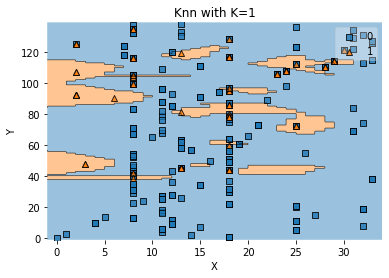

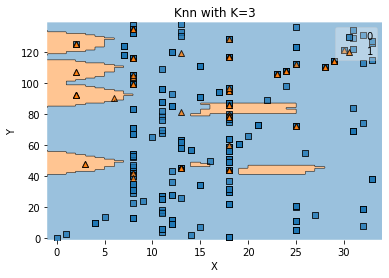

In [11]:
def knn_comparison(data, k):
    X = data[['country','location']].values
    Y = data['result' ].astype(int).values
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, Y)# Plotting decision region
    plot_decision_regions(X, Y, clf=clf, legend=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Knn with K='+ str(k))
    plt.show()
for i in [1,3]:
    knn_comparison(df, i)

### Precision, Recall and F1

In [12]:
y_val_pred = cross_val_predict(knn_gscv, x_val, y_val, cv=5)

In [13]:
print('Precision = ' + str(precision_score(y_val,y_val_pred, average="macro")))

Precision = 0.7976190476190477


In [14]:
print('Recall = ' + str(recall_score(y_val,y_val_pred, average="macro")))

Recall = 0.7456140350877193


In [15]:
print('F1 = ' + str(f1_score(y_val,y_val_pred, average="macro")))

F1 = 0.7677988869698713


## Precision and Recall Graph

Text(0, 0.5, 'Precision')

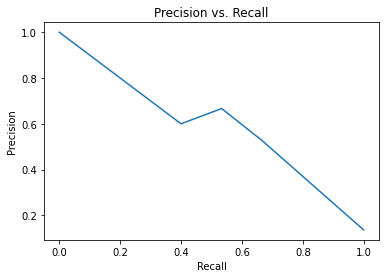

In [16]:
y_scores = cross_val_predict(knn_gscv, x_val, y_val, cv=5, method = "predict_proba")
ys = y_scores[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_val,ys)
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

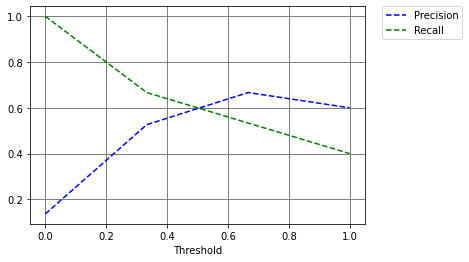

In [17]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

## ROC and AUC

Text(0, 0.5, 'True Positive Rate')

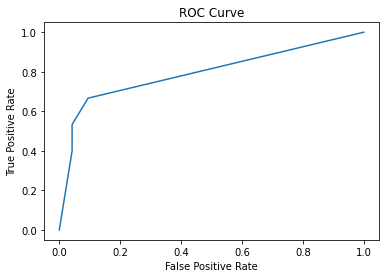

In [18]:
fpr, tpr, thresholds = roc_curve(y_val,ys)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [19]:
#Area under curve (AUC) value
roc_auc_score(y_val,ys)

0.7943859649122808

## Do the Same Calculations on Test Data

In [20]:
#y_test_pred = cross_val_predict(knn_gscv, x_test, y_test, cv=5)
y_test_pred= knn_gscv.predict(x_test)
print('Precision = ' + str(precision_score(y_test,y_test_pred, average="macro")))

Precision = 0.8897783251231527


In [21]:
print('Recall = ' + str(recall_score(y_test,y_test_pred, average = "macro")))

Recall = 0.7765399737876801


In [22]:
print('F1 = ' + str(f1_score(y_test,y_test_pred, average="macro")))

F1 = 0.8184126984126984


Text(0, 0.5, 'Precision')

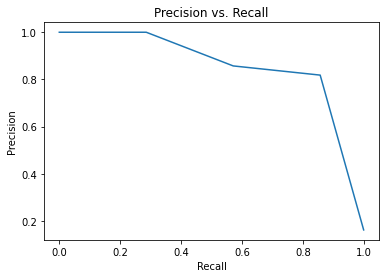

In [23]:
y_scores_test = knn_gscv.predict_proba(x_test)
precisions, recalls, thresholds = precision_recall_curve(y_test,y_scores_test[:,1])
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")


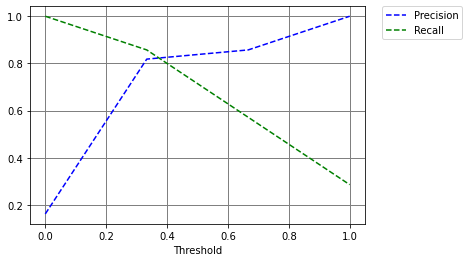

In [24]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

Text(0, 0.5, 'True Positive Rate')

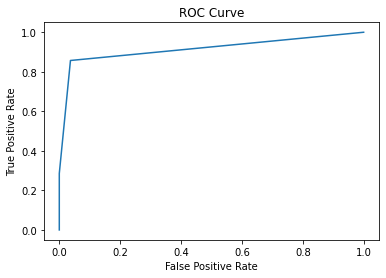

In [25]:
fpr, tpr, thresholds = roc_curve(y_test,y_scores_test[:,1])
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [26]:
roc_auc_score(y_test,y_test_pred)

0.7765399737876801

In [27]:
#testing accuracy
acc = knn.score(x_test,y_test)
print('Accuracy = ' + str(acc))

Accuracy = 0.9153846153846154


# Logistic Regression<a class="anchor" id="Logistic_Regression"></a>

In [28]:
#imports for Logistic Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [29]:
#Reading data 
data = pd.read_csv(r'data.csv', delimiter = ",",  header = 0, index_col = 0)

In [30]:
#splitting the data to X (features) and Y (results) 
X = data[["location","country","gender","age","vis_wuhan","from_wuhan","symptom1","symptom2","symptom3","symptom4","symptom5","symptom6","diff_sym_hos"]]
y = data["result"]

#dropping symptom5 and symptom6 as they are constant for all dataset
X.drop("symptom6", axis =1, inplace = True)
X.drop("symptom5", axis =1, inplace = True)


#splitting the data set into train data and test data
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.15, random_state=0, shuffle=True)

#splitting the train data into train data and validation data
X_train, X_val, y_train, y_val = train_test_split (X_train, y_train, test_size=0.15, random_state=0, shuffle=True)

## Hyper-Parameter Optimization

In [31]:
#creating instance of Logistic Regression
LR = LogisticRegression()

#Using GridSearch Function to tune Hyper-parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight':['balanced']}
LR_new = GridSearchCV(LR, param_grid,cv=5)

#training the Optimal model
LR_new.fit(X_train,y_train)

print("Optimal Hyperparameters: ", LR_new.best_params_)

Optimal Hyperparameters:  {'C': 100, 'class_weight': 'balanced'}


## Cross validating

In [ ]:
#cross validation prediction
cv_predict = cross_val_predict(LR_new, X_val, y_val, cv=5)

#decision function scores with validation data using cross validation
y_scores_validation = cross_val_predict(LR_new, X_val, y_val, cv=5, method="decision_function")

In [ ]:
#Printing out the confusion matrix
print("Confusion Matrix =\n", confusion_matrix(y_val, cv_predict))

## Calculating Precision, Recall, and F1-Scores

In [ ]:
#Calculating the average precision, recall and f1
print("Precision Score is = ", precision_score(y_val, cv_predict, average='macro'))
print("Recall Score is = ", recall_score(y_val, cv_predict, average='macro'))
print("F-1 Score is = ", f1_score(y_val, cv_predict, average='macro'))


## Visualizing Graphs

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_val,y_scores_validation)
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

In [ ]:
#Plotting Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores_validation)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.title('Precision/Recall Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
plt.show()

In [ ]:
#visualizing roc auc
fpr, tpr, thresholds = roc_curve(y_val, y_scores_validation)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve' )
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [ ]:
#calculating ROC/AUC score
Roc_Auc = roc_auc_score(y_val, cv_predict)
print("ROC/AUC Score = ", Roc_Auc)

In [ ]:
#classification report for precision - recall - F1-score
print(classification_report(y_val, cv_predict))

## Calculating Precision, Recall, and F1-Score using Test Data

In [ ]:
#model predictions with test data
test_predict = LR_new.predict(X_test)

#decision function scores with test data
y_scores_test = LR_new.decision_function(X_test)

In [ ]:
#Calculating the accuracy
print("Accuracy = ", accuracy_score(y_test ,test_predict))

In [ ]:
#Printing the confusion matrix
print("Confusion Matrix =\n", confusion_matrix(y_test, test_predict))

In [ ]:
#Calculating the average precision, recall and f1
print("Precision Score is = ", precision_score(y_test, test_predict, average='macro'))
print("Recall Score is = ", recall_score(y_test, test_predict, average='macro'))
print("F-1 Score is = ", f1_score(y_test, test_predict, average='macro'))

## Visualizing the Graphs

In [ ]:
#plotting Precision VS Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test,y_scores_test)
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")


In [ ]:
#Plotting Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_test)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.title('Precision/Recall Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
plt.show()

In [ ]:
#visualizing roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve' )
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [ ]:
#calculating ROC/AUC score
Roc_Auc = roc_auc_score(y_test, test_predict)
print("ROC/AUC Score = ", Roc_Auc)

In [ ]:
#classification report
print(classification_report(y_test, test_predict))

# Naive Bayes <a class="anchor" id="Naive_Bayes"></a> 

In [ ]:
#Imports for Naive Bayes
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap


from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets , metrics
from sklearn.metrics import confusion_matrix,f1_score,PrecisionRecallDisplay ,classification_report
from sklearn.metrics import precision_score,recall_score,precision_recall_curve , accuracy_score
from sklearn import svm, datasets

In [ ]:
#Create Naive Bayes classifier:
gnb = GaussianNB()

#Read dataset:
dataset = pd.read_csv(r"data.csv")

#Features in Variable X
X = dataset[["location", "country", "gender", "age", "vis_wuhan", "from_wuhan", "symptom1", "symptom2" , "symptom3" , "symptom4","symptom5" ,"symptom6", "diff_sym_hos"]]

#removed symptom6 as it is constant for all the dataset 
X.drop("symptom6", axis =1, inplace = True)
X.drop("symptom5", axis =1, inplace = True)

#Classes in Variable y
y= dataset["result"]


## Splitting the Data and Cross Validating

In [ ]:
#splitting the data to test and trian
X_train,X_test, y_train, y_test =  train_test_split (X,y, test_size= 0.2, random_state=0, shuffle= True)
#splitting the data to Validation and trian
X_train_2,X_validate, y_train_2, y_validate =  train_test_split (X_train,y_train, test_size= 0.2, random_state=0, shuffle= True)

#Training the Model
gnb.fit(X_train_2, y_train_2)

#Predicting the output using cross validation
y_CV_Pred = cross_val_predict(gnb, X_validate, y_validate, cv=5)

#Getting confusion Matrix
print(confusion_matrix(y_validate , y_CV_Pred))     # [ True Negative    // False Postive ]
                                                    # [ Fasle Negative   // True Postive  ]

## Calculating Precision, Recall, and F1-Score

In [ ]:
#calculating precision and reall
precision = precision_score(y_validate, y_CV_Pred, average= "macro")
recall = recall_score(y_validate, y_CV_Pred, average= "macro")
print("Recall: ", recall)
print("Precision: ", precision)

In [ ]:
#Getting F1_Score
F1 = f1_score(y_validate, y_CV_Pred, average= "macro")
print("F1_score: ", F1)


In [ ]:
#Getting Accuracy of the Model
print ("Accuracy: ", gnb.score(X_validate,y_validate))
cv_scores = cross_val_score(gnb, X_validate, y_validate, cv=5, scoring="accuracy")
print("Accuracy = ", cv_scores)


## Visualization of Graphs

In [ ]:
#Getting Scores of cross validation
y_scores = cross_val_predict(gnb, X_validate, y_validate, cv=5,method = "predict_proba")
y_scores_ = y_scores[:,1]

#Visualizing the Precision vs. Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_validate,y_scores_)
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")


In [ ]:
#Visualizing the Threshold Curve
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

In [ ]:
#Creating ROC 
fpr, tpr, thresholds = metrics.roc_curve(y_validate,y_score= y_scores_ )

#Visualizing ROC Curve
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian Naive Bayes ROC ")
plt.show()

In [ ]:
#Getting the AUC score
metrics.roc_auc_score(y_validate,y_CV_Pred)

In [ ]:
print(classification_report(y_validate, y_CV_Pred))

## Calculating the Precision, Recall, and F1-Sco with the Test Data

In [ ]:
#Predicting y
y_predict_2 = gnb.predict(X_test)

#Getting confusion Matrix
print(confusion_matrix(y_test , y_predict_2))     # [ True Negative    // False Postive ]
                                                  # [ Fasle Negative   // True Postive  ]

In [ ]:
#calculating precision and reall
precision = precision_score(y_test, y_predict_2, average= "macro")
recall = recall_score(y_test, y_predict_2, average= "macro")
print("Recall: ", recall)
print("Precision: ", precision)

In [ ]:
#Getting F1_Score
F1 = f1_score(y_test, y_predict_2, average= "macro")
print("F1_score: ", F1)


In [ ]:
#Getting Accuracy of the Model
print ("Accuracy: ", gnb.score(X_test,y_test))

## Visualization of Graphs using the Test Data

In [ ]:
#Getting Scores of test 
y_scores_test = gnb.predict_proba(X_test)

#Visualizing the Precision vs. Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_test[:,1])
plt.plot(recalls,precisions)
plt.title("Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")


In [ ]:
#Visualizing the Threshold Curve
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

In [ ]:
#Creating ROC 
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_score= y_scores_test[:,1] )

#Visualizing ROC Curve
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian Naive Bayes ROC ")
plt.show()

In [ ]:
#Getting the AUC score
metrics.roc_auc_score(y_test,y_predict_2)

In [ ]:
print(classification_report(y_test, y_predict_2))

# Visualizing the Data using scatter plots  <a class="anchor" id="Feature_visaulization"></a> 

In [ ]:
#plotting some features with the output to view the data
names = ["location", "country", "age",  "symptom1", "symptom2" , "symptom3" , "symptom4" , "diff_sym_hos"]

fig=plt.figure(figsize=(15,22))

for idx, i in enumerate(names):
    
    ax = fig.add_subplot(4,3,idx+1)
    plt.xlabel("{}".format(i))
    plt.ylabel("Result")
    plt.title("Plotting each Feature against the Result")
    ax.scatter(X[[i]], y)

In [ ]:
#plotting some features with the other features to view correlation between features
index=1
figure= plt.figure(figsize=(30,150))
for i in names:
    for j in names:
        if(i!=j):
            ax1 = figure.add_subplot(19,3,index)
            ax1.scatter(X[[i]],X[[j]] )
            plt.xlabel("{}".format(i))
            plt.ylabel("{}".format(j))
            plt.title("Plotting each Feature against the other Features")
            index+=1